## 修改训练集
## 修改网络结构，参考pilotnet
## 修改评估函数

## 0630测试
1. 分别以epoch10和epoch1作为测试集，其他9个epoch作为训练集，观察模型对训练数据和测试数据的拟合程度，确定是否由于epoch10数据显著区别于其他数据

## 0701测试
1.以epoch9做验证集，epoch10做测试集  
2.调整模型，优化validation loss
3.使用generator

## 结果，没有进展

In [1]:
import cv2
import numpy as np
import pandas as pd

In [ ]:
mkv_file_path = ['../epochs/epoch{:02d}_front.mkv'.format(i) for i in range(1,11)]
steering_file_path = ['../epochs/epoch{:02d}_steering.csv'.format(i) for i in range(1,11)]
paths = [mkv_file_path,steering_file_path]

In [ ]:
#数据预处理方法
def read_mkv(path):
    cap = cv2.VideoCapture(path)
    success,frame = cap.read()
    pic = []

    while(success):
        frame = frame[300:-50]
        frame = cv2.resize(frame,(224,64),interpolation=cv2.INTER_CUBIC)
        pic.append(frame)

        success,frame = cap.read()
    return np.array(pic)

def read_steering(path):
    return pd.read_csv(path).wheel.values

In [ ]:
# 读取epoch1~8视频和转向角度,作为训练集
train_x=[]
train_y = []
for i in range(2,10):
    train_x.append(read_mkv(paths[0][i]))
    train_y.append(read_steering(paths[1][i]))

#读取epoch9，作为验证集
val_x = read_mkv(paths[0][1])
val_y = read_steering(paths[1][1])

In [ ]:
# 保存视频和转向角度
train_x = np.concatenate(tuple(train_x))
train_y = np.concatenate(tuple(train_y))

np.save('../new_data/train_x2.npy',train_x)
np.save('../new_data/val_x2.npy',val_x)
print('feature saved successfully!')

np.save('../new_data/train_y2.npy',train_y)
np.save('../new_data/val_y2.npy',val_y)
print('label saved successfully!')

In [67]:
#加载数据
train_x = np.load('../new_data/train_x2.npy')
val_x = np.load('../new_data/val_x2.npy')
print('feature loaded successfully!')
train_y = np.load('../new_data/train_y2.npy')
val_y = np.load('../new_data/val_y2.npy')
print('label loaded successfully!')
print('train_x shape is: {}\nval_x shape is: {}'.format(train_x.shape,val_x.shape))

feature loaded successfully!
label loaded successfully!
train_x shape is: (21600, 66, 228, 3)
val_x shape is: (3900, 66, 228, 3)


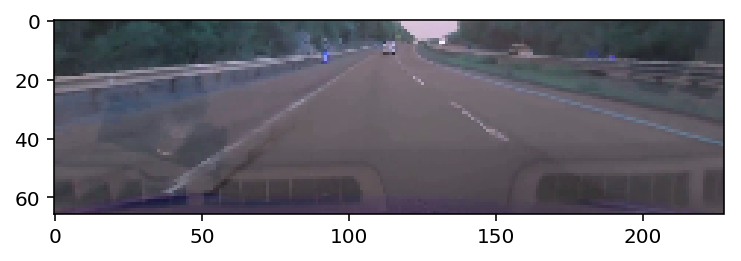

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.imshow(feature[np.random.randint(30000,40000)])

In [5]:
reversed_x = np.array([cv2.flip(image,1) for image in train_x])
reversed_y = -1*train_y

In [68]:

label = np.concatenate((train_y,val_y))

In [58]:
label = np.concatenate((label,val_y))

In [22]:
from sklearn.preprocessing import OneHotEncoder
b = OneHotEncoder()

In [69]:
s = pd.get_dummies(label)

In [88]:
train_y = s.values[:-3900]
val_y = s.values[-3900:]

In [84]:
train_y.shape

(21600, 67)

In [30]:
from keras.layers import Dense,Activation,Convolution2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from keras.layers.noise import GaussianNoise
from keras.models import Sequential
from keras.optimizers import Adam,Adadelta
from keras import regularizers

Using TensorFlow backend.


## My Net

In [80]:
model = Sequential()

# model.add(BatchNormalization(input_shape=(66,228,3)))
model.add(GaussianNoise(5,input_shape=(66,228,3)))
model.add(Convolution2D(kernel_size=(5,5),filters = 8,strides=(1,1),activation='relu',kernel_regularizer=regularizers.l2(0.01)))

# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())

model.add(Convolution2D(kernel_size=(3,3),filters = 64,strides=(1,1),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())

model.add(Convolution2D(kernel_size=(3,3),filters = 64,strides=(1,1),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

model.add(Convolution2D(kernel_size=(3,3),filters = 128,strides=(1,1),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(kernel_size=(3,3),filters = 256,strides=(1,1),activation='relu',kernel_regularizer=regularizers.l2(0.01)))

# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())

model.add(Convolution2D(kernel_size=(3,3),filters = 256,strides=(1,1),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(kernel_size=(3,3),filters = 256,strides=(1,1),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Convolution2D(kernel_size=(3,3),filters = 256,strides=(1,1),data_format='channels_last'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Convolution2D(kernel_size=(3,3),filters = 256,strides=(1,1),data_format='channels_last'))
# model.add(Activation('relu'))
# # model.add(BatchNormalization())

# model.add(Convolution2D(kernel_size=(3,3),filters = 256,strides=(1,1),data_format='channels_last'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# model.add(Dense(512))
# model.add(Activation('relu'))
# # model.add(BatchNormalization())
# model.add(Dropout(0.75))

model.add(Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(),bias_regularizer=regularizers.l2()))
# model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.add(Dense(1024))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(67))
model.add(Activation('softmax'))


In [62]:
import keras.backend as K

def missing_rate(y_true, y_pred):
    return K.mean(abs(y_pred-y_true))/33.

In [81]:
model.compile(optimizer='adadelta',
             loss = 'categorical_crossentropy',
             metrics = ['acc'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 66, 228, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 224, 8)        608       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 222, 64)       4672      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 111, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 109, 64)       36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 107, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 53, 128)       0         
__________

In [78]:
from keras.preprocessing.image import ImageDataGenerator
general = ImageDataGenerator(data_format='channels_last')

In [91]:
model.fit_generator(general.flow(train_x,train_y,batch_size=64),steps_per_epoch=len(train_x)/64,\
                    epochs=1,validation_data=(val_x,val_y))

Epoch 1/1
338/337 [==============================] - 99s - loss: 2.3525 - acc: 0.5657 - val_loss: 4.5090 - val_acc: 0.0838


In [87]:
model.fit(train_x,train_y,validation_data=(val_x,val_y))

ValueError: Input arrays should have the same number of samples as target arrays. Found 3900 input samples and 21600 target samples.

In [40]:
vy

,"Float64Index([-18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0], dtype='float64')_-3.5","Float64Index([-18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0], dtype='float64')_-3.0","Float64Index([-18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0], dtype='float64')_-2.5","Float64Index([-18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0], dtype='float64')_-2.0","Float64Index([-18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0], dtype='float64')_-1.5","Float64Index([-18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0], dtype='float64')_-1.0","Float64Index([-18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0], dtype='float64')_-0.5","Float64Index([-18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0], dtype='float64')_0.0","Float64Index([-18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3

In [ ]:
model.fit(feature,label,batch_size=64,validation_data=(val_x,val_y),epochs=5)

In [ ]:
#保存模型配置和权重
import h5py
model.save_weights('../models/mode_0702.h5')
with open('../models/model_0702.json','w') as f:
    f.write(model.to_json())
    f.close()
    

In [ ]:
s = read_mkv('./epochs/epoch10_front.mkv')
s.shape

In [ ]:
with open('../models/model_0702.json','r') as f:
    string = f.read()
from keras.models import model_from_json
model = model_from_json(string)
model.load_weights('../models/mode_0702.h5')

## 通过keras-vis可视化

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

from vis.utils import utils
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_class_saliency, overlay

In [ ]:
pre_x = np.array([cv2.imread('../transfer_image/_0_1517.jpeg')])

In [46]:
pre_x.shape

(1, 66, 228, 3)

In [52]:
seed_img = utils.load_img('../transfer_image/_100_4043.jpeg')

In [48]:
heatmaps = []

In [53]:
heatmap = visualize_class_saliency(model,14,filter_indices=0,seed_input=seed_img)

In [54]:
heatmaps.append(overlay(seed_img,heatmap))

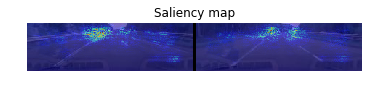

In [59]:
plt.axis('off')
plt.imshow(utils.stitch_images(heatmaps))
plt.title('Saliency map')
plt.show()

Failed to lookup font 'FreeSans.ttf', falling back to default


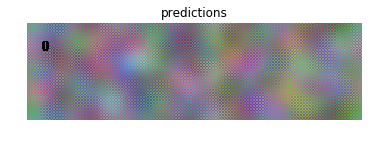

In [60]:
from matplotlib import pyplot as plt

from vis.utils import utils
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_class_activation


# Build the VGG16 network with ImageNet weights


# The name of the layer we want to visualize
# (see model definition in vggnet.py)


# Generate three different images of the same output index.
vis_images = []

img = visualize_class_activation(model, 14, filter_indices=0)
img = utils.draw_text(img, str(0))
vis_images.append(img)

stitched = utils.stitch_images(vis_images)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()
